In [1]:
import pandas as pd 
import numpy as np
import datetime


In [2]:
train_data = pd.read_csv("/opt/ml/code/input/train.csv", parse_dates=["order_date"])
train_data["year_month"] = train_data["order_date"].dt.strftime('%Y-%m')
train_data["year"] = train_data["order_date"].dt.strftime('%Y')

In [3]:
agg_func = ['mean','max','min','sum','count','std','skew']


In [4]:
len(pd.unique(train_data[train_data.year == "2010"]["order_date"]))

20807

In [5]:
train_year_st = '2009-12'
train_year = '2010-12'

validation_year_st = '2010-11'
validation_year = '2011-11'

test_year_st = '2010-12'
test_year = '2011-12'

train = train_data[(train_year_st <= train_data["order_date"]) & (train_data["order_date"] < train_year)]
validation = train_data[(validation_year_st <= train_data["order_date"]) & (train_data["order_date"] < validation_year)]
test = train_data[(test_year_st <= train_data["order_date"]) & (train_data["order_date"] < test_year)]

In [6]:
train

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.610,2009-12,2009
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.650,2009-12,2009
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.650,2009-12,2009
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.320,2009-12,2009
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.500,2009-12,2009
...,...,...,...,...,...,...,...,...,...,...,...
396275,536364,21175,GIN + TONIC DIET METAL SIGN,12,2010-11-30 19:35:00,3.4650,14441,United Kingdom,41.580,2010-11,2010
396276,536364,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-11-30 19:35:00,13.1175,14441,United Kingdom,26.235,2010-11,2010
396277,536364,21098,CHRISTMAS TOILET ROLL,12,2010-11-30 19:35:00,2.0625,14441,United Kingdom,24.750,2010-11,2010
396278,536364,21181,PLEASE ONE PERSON METAL SIGN,24,2010-11-30 19:35:00,3.4650,14441,United Kingdom,83.160,2010-11,2010


In [7]:
def generate_label(df, year_month, thres = 300, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [8]:
train_label = generate_label(train_data, train_year)[['customer_id','year_month','label']]
valid_label = generate_label(train_data, validation_year)[['customer_id','year_month','label']]
test_label = generate_label(train_data, test_year)[['customer_id','year_month','label']]

In [9]:
def get_final_data(df, agg_func, plus_columns=['total-mean', 'total-max', 'total-min', 'total-sum', 'total-count', 'total-std', 'total-skew']):
    ret_data = pd.DataFrame()
    for i, tr_ym in enumerate(df['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = df.loc[df['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        ret_data = ret_data.append(train_agg)
    
    for new_col in plus_columns:
        ret_data[new_col+"-1"] = ret_data[new_col]
    return ret_data

In [10]:
train_data_final = get_final_data(train, agg_func)

In [11]:
train_data_final = train_data_final.fillna(0)

In [12]:
valid_data_final = get_final_data(validation, agg_func)

In [13]:
valid_data_final = valid_data_final.fillna(0)

In [14]:
test_data_final = get_final_data(test, agg_func)

In [15]:
test_data_final = test_data_final.fillna(0)

In [16]:
temp = train_data_final[train_data_final.customer_id == 13085]

In [17]:
month_list = pd.unique(temp.year_month)

In [18]:
month_list

array(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10', '2010-11'],
      dtype=object)

In [19]:
temp.columns

Index(['customer_id', 'quantity-mean', 'quantity-max', 'quantity-min',
       'quantity-sum', 'quantity-count', 'quantity-std', 'quantity-skew',
       'price-mean', 'price-max', 'price-min', 'price-sum', 'price-count',
       'price-std', 'price-skew', 'total-mean', 'total-max', 'total-min',
       'total-sum', 'total-count', 'total-std', 'total-skew', 'year_month',
       'total-mean-1', 'total-max-1', 'total-min-1', 'total-sum-1',
       'total-count-1', 'total-std-1', 'total-skew-1'],
      dtype='object')

In [20]:
col_data = temp.drop(["customer_id", "year_month"], axis=1).columns

In [21]:
col_data

Index(['quantity-mean', 'quantity-max', 'quantity-min', 'quantity-sum',
       'quantity-count', 'quantity-std', 'quantity-skew', 'price-mean',
       'price-max', 'price-min', 'price-sum', 'price-count', 'price-std',
       'price-skew', 'total-mean', 'total-max', 'total-min', 'total-sum',
       'total-count', 'total-std', 'total-skew', 'total-mean-1', 'total-max-1',
       'total-min-1', 'total-sum-1', 'total-count-1', 'total-std-1',
       'total-skew-1'],
      dtype='object')

In [22]:
row = ['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11']

In [23]:
row_arr = []
for i in range(0, 2):
    for t in row:
        row_arr.append(t + "_" + str(i))

In [24]:
for i in row[-6:]:
    row_arr.append(i + "_2")

In [25]:
row_list = {date : i for i, date in enumerate(row_arr)}
col_list = {data : i for i, data in enumerate(col_data)}

In [26]:
data = {i : [] for i in range(0, 28 * 28)}

In [27]:
max_list = train_data_final.max()

In [28]:
min_list = train_data_final.min()


In [29]:
max_list

customer_id         18287
quantity-mean        4380
quantity-max        19152
quantity-min         4008
quantity-sum       218090
quantity-count       4892
quantity-std      4058.82
quantity-skew     17.3003
price-mean        41433.3
price-max         41433.3
price-min         41433.3
price-sum         65869.6
price-count          4892
price-std         4470.02
price-skew        33.4588
total-mean        4625.28
total-max         18073.3
total-min         4625.28
total-sum          481552
total-count          4892
total-std         20869.2
total-skew        14.2907
year_month        2010-11
total-mean-1      4625.28
total-max-1       18073.3
total-min-1       4625.28
total-sum-1        481552
total-count-1        4892
total-std-1       20869.2
total-skew-1      14.2907
dtype: object

In [30]:
customers = pd.unique(train_data_final.customer_id)
data["id"] = []
for customer_id in customers:
    temp = train_data_final[train_data_final.customer_id == customer_id]
    data["id"].append(customer_id)
    for date in row_arr:
        for col in col_data:
            t_date = date.split("_")[0]
            max_num = float(max_list[col])
            min_num = float(min_list[col])
            try:
                num = float(temp[temp.year_month == t_date][col])
                num = int(((num - min_num) / (max_num - min_num)) * 255.) if max_num != min_num else 0
            except:
                num = 0.0
                
            key = row_list[date] * 28 + col_list[col]
            
            data[key].append(num)

In [41]:
max_list = valid_data_final.max()
min_list = valid_data_final.min()

In [42]:
valid_data = {i : [] for i in range(0, 28 * 28)}
valid_data["id"] = []
for customer_id in customers:
    temp = valid_data_final[valid_data_final.customer_id == customer_id]
    valid_data["id"].append(customer_id)
    for date in row_arr:
        for col in col_data:
            t_date = date.split("_")[0]
            max_num = float(max_list[col])
            min_num = float(min_list[col])
            try:
                num = float(temp[temp.year_month == t_date][col])
                num = int(((num - min_num) / (max_num - min_num)) * 255.) if max_num != min_num else 0
            except:
                num = 0.0
            key = row_list[date] * 28 + col_list[col]
            valid_data[key].append(num)


In [43]:
max_list = test_data_final.max()
min_list = test_data_final.min()

In [44]:
test_data = {i : [] for i in range(0, 28 * 28)}
test_data["id"] = []
for customer_id in customers:
    temp = test_data_final[test_data_final.customer_id == customer_id]
    test_data["id"].append(customer_id)
    for date in row_arr:
        for col in col_data:
            t_date = date.split("_")[0]
            max_num = float(max_list[col])
            min_num = float(min_list[col])
            try:
                num = float(temp[temp.year_month == t_date][col])
                num = int(((num - min_num) / (max_num - min_num)) * 255.) if max_num != min_num else 0
            except:
                num = 0.0
            key = row_list[date] * 28 + col_list[col]
            test_data[key].append(num)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [34]:
train_df = pd.DataFrame(data)


In [35]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,id
0,5.0,1.0,163.0,1.0,0.0,0.0,72.0,0.0,0.0,0.0,...,0,136,229,177,228,20,2,0,136,12346
1,5.0,1.0,163.0,1.0,0.0,0.0,67.0,0.0,0.0,0.0,...,0,190,229,179,229,22,5,0,190,12349
2,6.0,2.0,163.0,2.0,0.0,1.0,82.0,0.0,0.0,0.0,...,1,174,229,179,229,21,1,1,174,12358
3,6.0,3.0,158.0,2.0,1.0,3.0,74.0,0.0,0.0,0.0,...,0,162,229,178,228,22,6,0,162,12359
4,5.0,1.0,163.0,1.0,0.0,0.0,67.0,1.0,1.0,1.0,...,0,156,230,178,230,20,0,0,156,12362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,162,229,177,229,20,1,0,162,18243
4010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,161,229,177,229,20,0,0,161,18266
4011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,150,229,177,229,20,0,0,150,18270
4012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,148,229,177,229,20,0,0,148,18278


In [45]:
valid_df = pd.DataFrame(valid_data)
test_df = pd.DataFrame(test_data)

In [46]:
train_df["label"] = train_label["label"]
valid_df["label"] = valid_label["label"]
test_df["label"] = test_label["label"]

In [47]:
train_df.to_csv("/opt/ml/code/my_src/data/train_img.csv")
valid_df.to_csv("/opt/ml/code/my_src/data/valid_img.csv")
test_df.to_csv("/opt/ml/code/my_src/data/test_img.csv")

In [48]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,id,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12346,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12349,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12358,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12359,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18243,0
4010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18266,0
4011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18270,0
4012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18278,0


In [49]:
valid_df

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,id,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12346,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12349,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12358,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12359,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18243,0
4010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18266,0
4011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18270,0
4012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18278,0


In [50]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,id,label
0,5.0,1.0,163.0,1.0,0.0,0.0,72.0,0.0,0.0,0.0,...,136,229,177,228,20,2,0,136,12346,0
1,5.0,1.0,163.0,1.0,0.0,0.0,67.0,0.0,0.0,0.0,...,190,229,179,229,22,5,0,190,12349,1
2,6.0,2.0,163.0,2.0,0.0,1.0,82.0,0.0,0.0,0.0,...,174,229,179,229,21,1,1,174,12358,1
3,6.0,3.0,158.0,2.0,1.0,3.0,74.0,0.0,0.0,0.0,...,162,229,178,228,22,6,0,162,12359,0
4,5.0,1.0,163.0,1.0,0.0,0.0,67.0,1.0,1.0,1.0,...,156,230,178,230,20,0,0,156,12362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,162,229,177,229,20,1,0,162,18243,0
4010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,161,229,177,229,20,0,0,161,18266,0
4011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,150,229,177,229,20,0,0,150,18270,0
4012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,148,229,177,229,20,0,0,148,18278,0


In [74]:
temp = train_df[train_df.id == 12346].drop(["label", "id"], axis=1)

In [64]:
temp

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,5.0,1.0,163.0,1.0,0.0,0.0,72.0,0.0,0.0,0.0,...,2,0,136,229,177,228,20,2,0,136


In [75]:
import numpy as np
from PIL import Image

In [81]:
temp = np.array(temp, dtype=int)

In [87]:
temp = temp.reshape(28, 28)

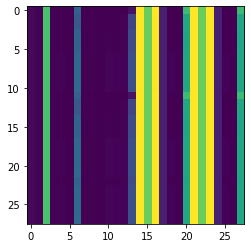

In [88]:
plt.imshow(temp)

In [80]:
temp.shape

(1, 28, 28)

In [3]:
import image_generate

In [4]:
train_year = {"start": "2009-12", "end": "2010-12"}
valid_year = {"start": "2010-11", "end": "2011-11"}
test_year = {"start": "2010-12", "end": "2011-12"}

train, valid, test = image_generate.generate_image(train_data, train_year, valid_year, test_year)

KeyError: 784